In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from keras.models import Sequential
from keras.layers import Dense, GRU, Bidirectional
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from data_handler import time_series_data_handler

Using TensorFlow backend.


## Notice on data set

The dataset is measurement from real operational chemical plants. For secuiry reaseon, all data are de-titled.
And also arbitrary renamed as Control group A,B,C and D. data was collected every single minutes. i.e. time space between data point is 1 minute.

### Hyper parameters for data handling

1. Input time step:
    Input time sereis has dimension of [number of input feature x input_time_step]
2. Targe time step:
    Input time sereis has dimension of [number of input feature x input_time_step]
3. Overlap:
    For the purpose of data argumentation. original time series data are splited in overlaped fashion.
    <br /> For example: X is a sequence of observations; X = X1,X2,X3,X4,X4, ... XN.
    <br /> If Input time step = 3, Overlap = 2, Then, input data collections will be as follows
    <br /> Training_X = [(X1,X2,X3),(X2,X3,X4),(X3,X4,X5), ... (XN-2,XN-1,XN)]
4. Scailing bound:
     Recurrent Neural Network is very sensitivy to the range of input features. 
     <br />Hence, all data are feature-wisely rescailed into range of scailing bound.
     
### Purpose of prediction task

The purpose of model inference is predicting 30 min future viscosity value in chemical process. The process is controlled by
4 groups of control inputs; A,B,C,D. All inputs are applied to the process synchronously.

In [2]:
data_path = './data/viscosity.csv'

# Input controls are devided into 4 groups; A,B,C,D
A = [3,4]
B = [8,2,5]
C = [1,9]
D = [6,11,10]

# Target of prediction is Y (or Z or both)
Y_Z = [7,12]

input_cols = A+B+C+D
target_cols = [7]

# We explicitly assume prediction operation has depedencies for markvoian 12 orders.
input_time_step = 12

# Here the model will predict 30 min after future value
time_lag = 30
target_time_step =1

# a naive input arguementation technique.
overlap = input_time_step - 1

# Recurrent Neural Network is very sensitivy to the range of input features.
# Normalzing data feature-wisely is helpful for model's prediction performance.
scaling_bound = [-1,1] 

data_handler = time_series_data_handler(datapath= data_path, input_columns = input_cols,\
                                           target_columns = target_cols, input_time_step = input_time_step,\
                                            target_time_step = target_time_step, time_lag= time_lag, overlap = overlap,\
                                           scaling_bound = scaling_bound, skiprows = 2)

(12, 10, 10008)
(1, 1, 9978)


In [3]:
#### Fit into appropriate dimension ####
data_handler.train_y = np.squeeze(data_handler.train_y)
data_handler.test_y = np.squeeze(data_handler.test_y)

In [4]:
# create and fit the RNN
model = Sequential()
model.add(Bidirectional(GRU(250, return_sequences=True, dropout = 0.0, recurrent_dropout=0.0, recurrent_activation='tanh'), input_shape=(input_time_step, len(input_cols))))
model.add(GRU(200, return_sequences=True, dropout = 0.0, recurrent_dropout=0.0, recurrent_activation='tanh'))
model.add(GRU(150, return_sequences=True, dropout = 0.3, recurrent_dropout=0.0, recurrent_activation='tanh'))
model.add(GRU(100, dropout = 0.4, recurrent_dropout=0.3, recurrent_activation='tanh'))
model.add(Dense(50, activation="relu"))
model.add(Dense(50, activation="relu"))
model.add(Dense((target_time_step)))

# Declare callbacks
ckpt = ModelCheckpoint(filepath = "./model_saves/weights.{epoch:02d}-{val_loss:.2f}.hdf5",verbose=1, save_best_only = True)
er_cb = EarlyStopping(patience=0)

# Declare a gradient descenter.
gd = Adam(lr = 0.001)
model.compile(loss='mean_squared_error', optimizer=gd)
model.fit(data_handler.train_x, data_handler.train_y, epochs=40, batch_size=128, verbose=2, validation_split=0.2,  callbacks=[ckpt,er_cb])

Train on 6384 samples, validate on 1597 samples
Epoch 1/40
Epoch 00000: val_loss improved from inf to 0.00946, saving model to ./model_saves/weights.00-0.01.hdf5
3s - loss: 0.0512 - val_loss: 0.0095
Epoch 2/40
Epoch 00001: val_loss improved from 0.00946 to 0.00257, saving model to ./model_saves/weights.01-0.00.hdf5
2s - loss: 0.0032 - val_loss: 0.0026
Epoch 3/40
Epoch 00002: val_loss improved from 0.00257 to 0.00036, saving model to ./model_saves/weights.02-0.00.hdf5
2s - loss: 0.0016 - val_loss: 3.6235e-04
Epoch 4/40
Epoch 00003: val_loss improved from 0.00036 to 0.00010, saving model to ./model_saves/weights.03-0.00.hdf5
2s - loss: 9.3287e-04 - val_loss: 1.0443e-04
Epoch 5/40
Epoch 00004: val_loss improved from 0.00010 to 0.00007, saving model to ./model_saves/weights.04-0.00.hdf5
2s - loss: 5.8287e-04 - val_loss: 6.6723e-05
Epoch 6/40
Epoch 00005: val_loss improved from 0.00007 to 0.00006, saving model to ./model_saves/weights.05-0.00.hdf5
2s - loss: 3.8651e-04 - val_loss: 5.9285e-0

In [5]:
# evaluate models
trainPredict = model.predict(data_handler.train_x)
testPredict = model.predict(data_handler.test_x)

# take inverse transform.
trainPredict = data_handler.target_data_scaler.inverse_transform(trainPredict)
trainY = data_handler.target_data_scaler.inverse_transform(data_handler.train_y)

testPredict = data_handler.target_data_scaler.inverse_transform(testPredict)
testY = data_handler.target_data_scaler.inverse_transform(data_handler.test_y)

/home/jyp/tensorflow/local/lib/python2.7/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/jyp/tensorflow/local/lib/python2.7/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


In [6]:
# Plotting
testPredicitonPlot = np.squeeze(testPredict)
testTruthPlot = np.squeeze(testY)

## Test set predciton result

The blue bold line is a prediction result. The green line is corresponding ground truth. Model looks succesfully predict 30 min futures. One interesting remarks is observed. After 900th data point. We can observe sharp oscillations in ground truth. Recall that the ground truth is measurement of viscosity at certain point of process. That means sharp oscillations is physically impossible. We can tentatively conclude that It is highly likely that measurement error were occured.

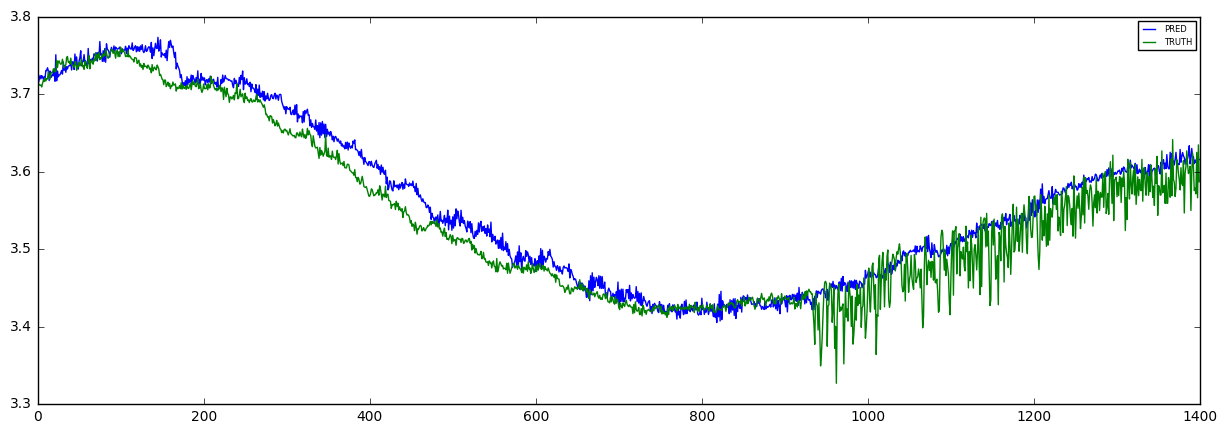

In [7]:
starting_idx = 0
ending_idx = 1400

fig = plt.figure(figsize=(15, 5), dpi=100)
pr_pred, = plt.plot(testPredicitonPlot[starting_idx:ending_idx], label="PRED")
pr_truth, = plt.plot(testTruthPlot[starting_idx:ending_idx], label="TRUTH")
plt.legend(handles=[pr_pred,pr_truth], loc=1,prop={'size':6})

plt.show()

In [8]:
testX = data_handler.test_x
concatX = np.vstack([testX[i,0,:] for i in range(testX.shape[0])])
trainX = data_handler.train_x
TconcatX = np.vstack([trainX[i,0,:] for i in range(trainX.shape[0])])

## Training input data distribution

Model was able to capture underlying dynamic of chemcial process under severaly and cosntantly varying input conditions. Following figure show the values of trainig input data. From every sensor group one time series was chosen for visualization.

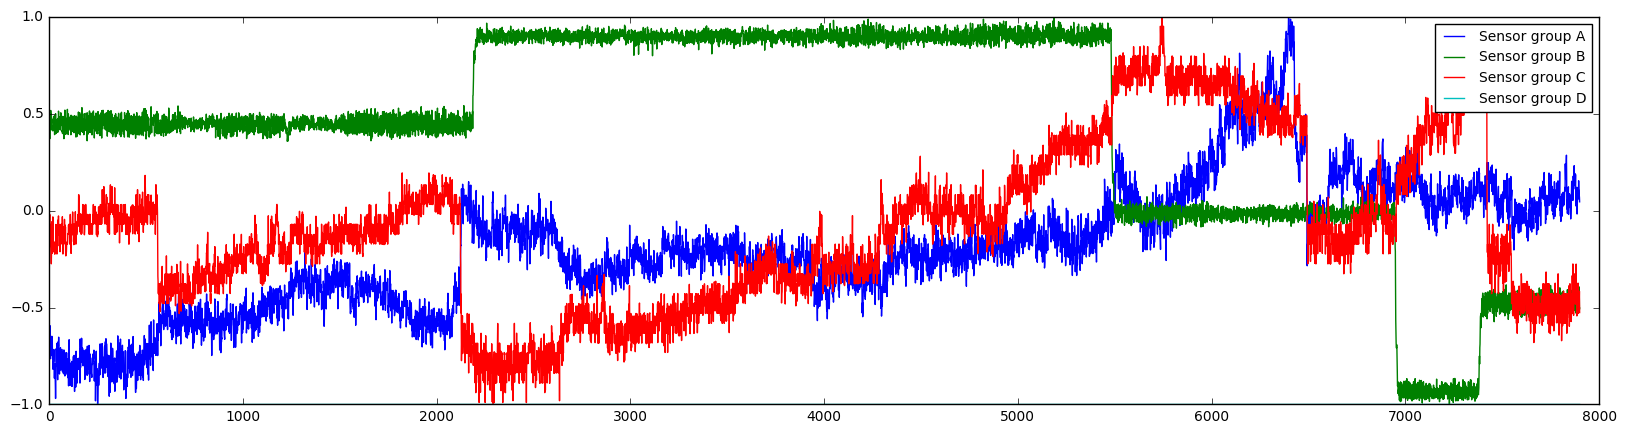

In [9]:
Tstarting_idx = 0
Tending_idx = 7900

fig = plt.figure(figsize=(20, 5), dpi=100)
pr_sensor1, = plt.plot(TconcatX[Tstarting_idx:Tending_idx,4], label="Sensor group A")
pr_sensor2, = plt.plot(TconcatX[Tstarting_idx:Tending_idx,2], label="Sensor group B")
pr_sensor3, = plt.plot(TconcatX[Tstarting_idx:Tending_idx,9], label="Sensor group C")
pr_sensor4, = plt.plot(TconcatX[Tstarting_idx:Tending_idx,6], label="Sensor group D")
plt.legend(handles=[pr_sensor1,pr_sensor2,pr_sensor3,pr_sensor4], loc=1,prop={'size':10})
plt.show()

## Test input data distribution

In similar manner, we can visuailize test input time series. Also, model was exposed to the constantly chaning input enviroment.

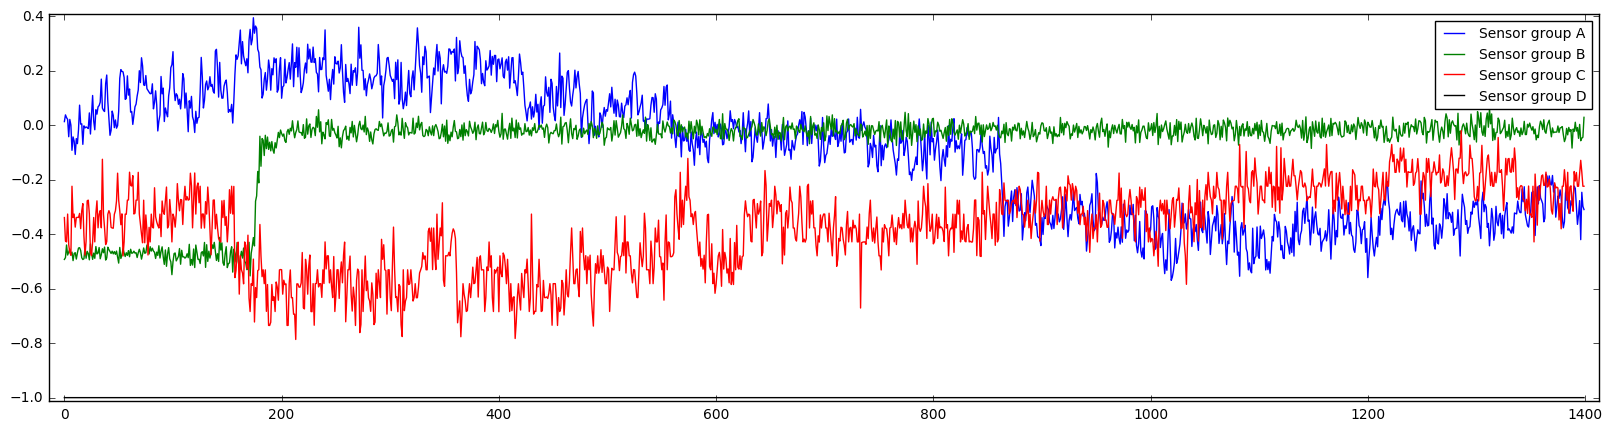

In [10]:
fig = plt.figure(figsize=(20, 5), dpi=100)
pr_sensor1, = plt.plot(concatX[starting_idx:ending_idx,4], label="Sensor group A")
pr_sensor2, = plt.plot(concatX[starting_idx:ending_idx,2], label="Sensor group B")
pr_sensor3, = plt.plot(concatX[starting_idx:ending_idx,9], label="Sensor group C")
pr_sensor4, = plt.plot(concatX[starting_idx:ending_idx,6], label="Sensor group D", color ='k', linewidth=1.0)
plt.legend(handles=[pr_sensor1,pr_sensor2,pr_sensor3,pr_sensor4], loc=1,prop={'size':10})
plt.margins(0.01)
plt.show()